### Sea-ice volume fluxes in the Beaufort Sea region for WRF10

#### Author: Jonathan Rheinlænder*
#### Date: Aug. 30 2021
#### Affiliation: Nansen Environmental and Remote Sensing Center, Bergen, Norway
*jonathan.rheinlaender@nersc.no

In [ ]:
%matplotlib inline
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
import struct
import xarray as xr
from datetime import datetime
import matplotlib as mpl
import sys
import os
import datetime as dt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid.inset_locator import inset_axes
import pynextsim.projection_info as projection_info 
import matplotlib.dates as mdates
import pandas as pd
import get_volumeflux

In [ ]:
def make_figure(wi, hi, nrow,ncol):

    fig = plt.figure(figsize=(wi,hi))
    #plt.subplots_adjust(hspace=5, wspace=0.01, top=0.95, bottom=0.1, left=0.075, right=0.925)
    gs = gridspec.GridSpec(nrow,ncol)
    
    return fig, gs 


In [ ]:
# load data
rootdir = '/home/rheinlender/shared-simstore-ns9829k/'
inpath = rootdir + 'home/rheinlender/data/nextsim-output/breakup2013/start_20130213_nudging/'
outpath_plots =  rootdir + 'home/rheinlender/figs/breakup-paper/'

expts_names = ["wrf10"]
fl = inpath + 'expt_01_wrf10/outputs/Moorings.nc'

ds = xr.open_dataset(fl)
print("opening:", fl)


## Ice flux in the Beaufort Sea for WRF10 

In [ ]:
time = ds['time'].time.values.astype('datetime64[ms]').astype('O')
    
# add new data variable 'thick_ice' to ds 
ds['sit_thick'] = ds['sit'] - ds['sit_thin']

# define thickness categories for fluxes
case0 = ds['sit'].where(ds.sit <= 1) # ice thinner than 1 m (thin ice)
case1 = ds['sit'].where((ds.sit>1) & (ds.sit <= 1.6)) # ice thicker than 1 m and thinner than 1.6 m (FYI)
case2 = ds['sit'].where(ds.sit > 1.6) # ice thicker than 1.6 m (MYI)

# subset region: Beaufort Sea
x0=0; x1=260
y0=150; y1=410
bbox =  (y0, y1, x0, x1)

# get fluxes 
iceflux0 = get_volumeflux.get_vol_fluxes(ds, case0, bbox, res=5e3)
iceflux1 = get_volumeflux.get_vol_fluxes(ds, case1, bbox, res=5e3)
iceflux2 = get_volumeflux.get_vol_fluxes(ds, case2, bbox, res=5e3)

dt = 3*(60*60) # 3hrs in sec
cumflux0 = np.cumsum(iceflux0*dt) # cumulative sum
cumflux1 = np.cumsum(iceflux1*dt) # cumulative sum
cumflux2 = np.cumsum(iceflux2*dt) # cumulative sum

# get colormap from tab20c
col=plt.cm.Blues([50,100, 150, 200])


fig, ax = plt.subplots(1,1, figsize=(3.5,2.5))

ax.stackplot(time, cumflux0*1e-9 ,cumflux1*1e-9,  cumflux2*1e-9,  
             alpha=0.9, colors=col, edgecolor=col[3], lw=0.3)
#ax.plot(time,  (cumflux1+cumflux2+cumflux0)*1e-9 )

#ax.bar(time, cumflux1*1e-9, bottom= cumflux2*1e-9)
plt.legend(['<1 m', '1$-$1.6 m', '>1.6 m'], loc='upper left')

days = mdates.DayLocator()  # every day
dtFmt = mdates.DateFormatter('%b %d') # define the formatting     
ax.xaxis.set_major_formatter(dtFmt)
ax.xaxis.set_minor_locator(days)
plt.xticks(rotation=25) # rotate xlabels
ax.grid(linestyle='--', alpha=0.2)
ax.set_ylabel('Ice flux (km$^3$)')
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())

fig.subplots_adjust(bottom=0.1, top=0.98, left=0.0, right=1, wspace=0.01, hspace=0.01)
plt.show()

# save figure
figname = os.path.join(outpath_plots,
      '%s%s_%s%s' % (outpath_plots, 'stacked-iceflux_beaufortBox',expts_names,'.png'))
print("saving...", figname)
fig.savefig(figname, dpi=300, bbox_inches='tight')

## Ice volume fluxes through different gates and for different categories

0 ('siv', 1, 410, slice(0, 261, None))
siv 1 410 slice(0, 261, None)
siv 1 410 slice(0, 261, None)
siv 1 410 slice(0, 261, None)
1 ('siu', 1, slice(281, 411, None), 260)
siu 1 slice(281, 411, None) 260
siu 1 slice(281, 411, None) 260
siu 1 slice(281, 411, None) 260
2 ('siu', 1, slice(150, 281, None), 260)
siu 1 slice(150, 281, None) 260
siu 1 slice(150, 281, None) 260
siu 1 slice(150, 281, None) 260
3 ('siv', -1, 150, slice(0, 261, None))
siv -1 150 slice(0, 261, None)
siv -1 150 slice(0, 261, None)
siv -1 150 slice(0, 261, None)


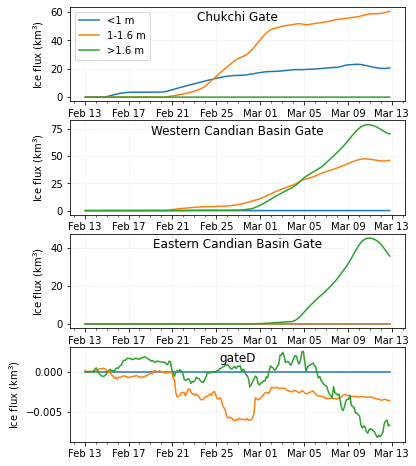

In [9]:
###### A #####
#            #
#            B    
#            #    
#            #
#            #    
#            C    
#            #
###### D #####    

gateA = ('siv', 1,  410, slice(0, 261)) # top
gateB = ('siu', 1,  slice(281, 410+1), 260)
gateC =  ('siu', 1,  slice(150, 280+1), 260)
gateD =  ('siv', -1, 150, slice(0, 260+1)) #bottom

# initilize
Vflux = 0
Vflux0_total = 0
Vflux1_total = 0
Vflux2_total = 0 

res=5e3
cell_area = res**2
fig, ax = plt.subplots(4,1, figsize=(6,8))
gatename = ['Chukchi Gate', 'Western Candian Basin Gate', 'Eastern Candian Basin Gate', 'gateD']
for n, gate in enumerate([gateA, gateB, gateC, gateD]):
    print(n, gate)
    
    Vflux0 = get_volumeflux.flux_through_gate(ds, case0, gate, res=5e3) # ice thinner than 1 m (thin ice)
    Vflux1 = get_volumeflux.flux_through_gate(ds, case1, gate, res) # ice thicker than 1 m and thinner than 1.6 m (FYI)
    Vflux2 = get_volumeflux.flux_through_gate(ds, case2, gate, res) # ice thicker than 1.6 m (MYI)

    # total flux (sum through all gates)
    Vflux0_total += Vflux0
    Vflux1_total += Vflux1
    Vflux2_total += Vflux2
    
    # cumulative flux    
    dt = 3*(60*60) # 3hrs in sec
    cumflux0 = np.cumsum(Vflux0*dt)
    cumflux1 = np.cumsum(Vflux1*dt)
    cumflux2 = np.cumsum(Vflux2*dt)

    ax[n].plot(time, cumflux0*1e-9, label='<1 m')
    ax[n].plot(time, cumflux1*1e-9, label='1-1.6 m')
    ax[n].plot(time, cumflux2*1e-9, label='>1.6 m')
        
    # axes stuff
    ax[n].set_title(gatename[n], y=1.0, pad=-14)
    days = mdates.DayLocator()  # every day
    dtFmt = mdates.DateFormatter('%b %d') # define the formatting     
    ax[n].xaxis.set_major_formatter(dtFmt)
    ax[n].xaxis.set_minor_locator(days)
    ax[n].grid(linestyle='--', alpha=0.2)
    ax[n].set_ylabel('Ice flux (km$^3$)')

ax[0].legend()
